<h1> ______________________________________ </h1>

<h1> Fiber panels with Kr38m decays simulation analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we analyse the results from the 10000 MC Kr38m decay events simulated in a "realistic" fiber barrel to check if we're able to see the krypton signal with enough resolution. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100 events. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [2]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

<h1> _________________________________________________________________________________________________________ </h1>


<h1> __________________________ </h1>
<h2> Functions </h2>

-  <p style="font-size: 17px; color: black;"> <b> gauss(x, a,  mu, sigma): </b> Gaussian normalized to $a$. </p>


-  <p style="font-size: 17px; color: black;"> <b> gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1): </b> Sum of 2 gaussians. </p>


-  <p style="font-size: 17px; color: black;"> <b> dirac(x, x0): </b> Dirac delta at $x0$. </p>




In [3]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

def dirac(x, x0):
    return np.where((x - x0) == 0, 1, 0)

def EL_yield(E, p, d):
    # E[kV/cm] electric field 
    # p[bar] pressure
    # d[cm] average absorption depth
    return (140*E/p - 116)*d*p # [photons/e⁻]


In [4]:
def dark_rate(dark25, dT, T):
    
#     dark25[Kcps] Dark rate at 25ºC
#     dT[ºC] Decay constant at which dark rate halves
#     T[ºC] Temperature

    exponent = (T - 25)/dT

    dark_rate = dark25*(2**exponent)
    
    return dark_rate

In [5]:
def noise(dark_rate, x_talk, t0, tf, dt, n_sensors):
    
#     dark_rate[Kcps] Number of dark pulses per second
#     x_talk[%] Cross talk probability (so the dark pulse is 2pe instead of 1pe)
#     t0[s] Measurements STARTING time
#     tf[s] Measurements ENDIND time
#     dt[s] Width of the time bin

    """
    Here we do it explained with all the steps, it can be done easier tho

    n_bin = (tf - t0)/dt

    pulse_rate = dark_rate*1e3*dt # probability of having a dark pulse in a bin
    
    pe1 = (1 - x_talk/100) # probability of that pulse being 1pe signal
    pe2 = x_talk/100 # probability of that pulse being 2pe signal

    n_1pe = int(pulse_rate*pe1*n_bin) # number of 1pe dark counts throughout measurement time in 1 sensor
    n_2pe = int(pulse_rate*pe2*n_bin) # number of 2pe dark counts throughout measurement time in 1 sensor
    
    """;
    
    pe1 = (1 - x_talk/100) # probability of that pulse being 1pe signal
    pe2 = x_talk/100 # probability of that pulse being 2pe signal
        
    n_1pe = dark_rate*1e3*(tf - t0)*pe1 # number of 1pe dark counts throughout measurement time in 1 sensor for 1 event
    n_2pe = dark_rate*1e3*(tf - t0)*pe2 # number of 2pe dark counts throughout measurement time in 1 sensor for 1 event
    
    n_1pe = n_1pe*n_sensors # TOTAL number of 1pe dark counts throughout measurement time for all sensors for 1 event
    n_2pe = n_2pe*n_sensors # TOTAL number of 2pe dark counts throughout measurement time for all sensors for 1 event

    n_1pe = int(n_1pe)
    n_2pe = int(n_2pe)
    
    return n_1pe, n_2pe

<h1> __________________________ </h1>
<h2> Global parameters </h2>

-  <p style="font-size: 17px; color: black;"> <b> Pandas dataset params: </b> Allows to set the max number of columns and rows that are shown in a pandas dataset. </p>

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

-  <p style="font-size: 17px; color: black;"> <b> Plots params: </b> In case you want to fix the parameters for all plots. </p>

In [7]:
# plt.rcParams["figure.figsize"] = 10, 8
# plt.rcParams["font.size"] = 10

-  <p style="font-size: 17px; color: black;"> <b> Analysis parameters </b> </p>

 -  <p style="font-size: 17px; color: black;"> <b> dark_rate: </b> Dark pulses rate. </p>
 -  <p style="font-size: 17px; color: black;"> <b> x_talk: </b> Cross talk probability. </p>
 -  <p style="font-size: 17px; color: black;"> <b> n_sensors: </b> Total number of sensors used. </p>
 

In [8]:
dark25 = 2000 # [Kcps] (1Kcps = 1e3 dark pulses per second) at 25ºC
x_talk = 7 # [%] Probability of a dark count to be 2pe instead of 1pe
n_sensors = 90 
t_binning = 0.1 # [ns] Conversion constant from bin enumerations to nanoseconds (binning used in the simulation)
dT = 5.3 # [ºC] Decay factor at which the dark rate halves

<h1> __________________________ </h1>
<h2> Data </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [9]:
path = '/home/investigator/mariandbt/python/data/'
path = path + '/20230824_fib_pan_kr'

# path = '/home/investigator/mariandbt/nexus'

filename = os.path.join(path, "Fib_pan_meth.next.h5")

-  <p style="font-size: 17px; color: black;"> In a .h5 file there are several objects, so we print them all to then pick the one we're interested in </p>

In [10]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/python/data//20230824_fib_pan_kr/Fib_pan_meth.next.h5 (File) ''
Last modif.: '2023-08-30T08:26:44+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(43,)) ''
/MC/hits (Table(0,)) ''
/MC/particles (Table(240222,)) ''
/MC/sns_positions (Table(90,)) ''
/MC/sns_response (Table(2809,)) ''



-  <p style="font-size: 17px; color: black;"> Read the file and make a copy to work with, this way it's easier to re-start the copy instead of re-reading the file. </p>

In [11]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
# data = pd.read_hdf(filename, "/MC/particles")
# data = pd.read_hdf(filename, "/MC/sns_positions")
data = pd.read_hdf(filename, "/MC/sns_response")
# data = pd.read_hdf(filename, "/MC/hits")
# dst = pd.read_hdf(filename, "/MC/hits").groupby("event_id").get_group(event_id)

In [12]:
dst = data.copy()

In [13]:
dst.time_bin = dst.time_bin*t_binning # change units to ns

In [14]:
# dst.final_volume.unique() 
# dst.initial_volume.unique()
# dst.particle_name.unique()
dst.sensor_id.unique(), len(dst.sensor_id.unique())

(array([3104, 3126, 3111, 3153, 3152, 3078, 3081, 3125, 3140, 3123, 3165,
        3132, 3163, 3131, 3084, 3151, 3150, 3086, 3089, 3139, 3161, 3103,
        3133, 3115, 3137, 3093, 3146, 3148, 3141, 3100, 3079, 3085, 3121,
        3091, 3135, 3097, 3124, 3102, 3101, 3157, 3109, 3149, 3159, 3118,
        3166, 3110, 3142, 3158, 3117, 3112, 3154, 3098, 3122, 3107, 3155,
        3145, 3130, 3143, 3092, 3147, 3094, 3082, 3106, 3087, 3116, 3096,
        3129, 3127, 3088, 3114, 3160, 3095, 3134, 3136, 3120, 3167, 3105,
        3080, 3083, 3119, 3162, 3113, 3144, 3099, 3108, 3128, 3138, 3090,
        3164, 3156], dtype=uint32),
 90)

In [15]:
dst.time_bin.unique(), len(dst.time_bin.unique())
dst.charge.unique(), len(dst.charge.unique())


(array([1, 2], dtype=uint32), 2)

In [16]:
# dst.loc[dst.final_volume.str.contains('SENS')]
# dst.loc[(dst.initial_volume != 'WORLD') & (dst.primary == 0)]
dst

,event_id,sensor_id,time_bin,charge
0,0,3104,41.7,1
1,0,3126,73.9,1
2,0,3126,265.5,1
3,0,3111,57.8,1
4,0,3111,114.3,1
5,0,3111,122.3,1
6,0,3111,145.0,1
7,0,3153,56.6,1
8,0,3152,28.0,1
9,0,3152,139.4,1


-  <p style="font-size: 17px; color: black;"> <b> Tests on the data: </b> We perform some tests on the dataset to check the simulation is valid. </p>

-  <p style="font-size: 17px; color: black;"> Group the data by sensors. </p>

In [17]:
dst.charge.sum(), len(dst.charge)

(2811, 2809)

In [18]:
# g = dst.groupby(dst.sensor_id)
g = dst.groupby(dst.event_id)


In [19]:
# g.charge.sum()

<h1> __________________________ </h1>
<h2> Analysis </h2>

In [20]:
dst_particle = pd.read_hdf(filename, "/MC/particles")
dst_particle.loc[dst_particle.particle_name == 'opticalphoton']
dst_particle.loc[(dst_particle.particle_name == 'opticalphoton') & 
                 (dst_particle.final_volume.str.contains('SENS')) 
                ]


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
88,0,92,opticalphoton,0,91,-101.034393,471.774384,608.361877,20.827251,-101.410500,472.352844,750.200012,41.775280,Y11,F_SENSOR_SENSAREA,-1.700529e-06,-3.464300e-07,-1.820112e-06,3.332964e-07,1.703152e-06,1.820112e-06,0.000003,3949.723633,OpWLS,Transportation
177,0,180,opticalphoton,0,179,293.094391,387.817383,-623.908936,322.147797,292.364288,387.970398,750.200012,337.154694,Y11,F_SENSOR_SENSAREA,2.014165e-06,5.436547e-07,-1.402359e-06,-3.664395e-07,-2.053812e-06,1.402359e-06,0.000003,2870.962158,OpWLS,Transportation
193,0,224,opticalphoton,0,223,-188.325943,-448.518250,180.387909,225.222214,-482.079529,34.103718,750.200012,265.551147,Y11,F_SENSOR_SENSAREA,-7.859104e-07,1.943962e-06,-1.289447e-06,8.871043e-07,-1.041232e-06,2.046509e-06,0.000002,12029.301758,OpWLS,Transportation
218,0,240,opticalphoton,0,239,-206.471771,437.920685,-115.611488,109.364807,-205.945297,438.591980,750.200012,114.309242,Y11,F_SENSOR_SENSAREA,-6.077527e-07,6.187346e-07,2.172306e-06,8.407396e-07,2.129616e-07,2.172306e-06,0.000002,932.266418,OpWLS,Transportation
231,0,247,opticalphoton,0,245,300.891235,-383.496460,-293.846588,50.884472,300.984009,-383.705933,750.200012,56.686226,Y11,F_SENSOR_SENSAREA,1.737629e-07,-6.968215e-07,2.296339e-06,3.229482e-07,-6.414501e-07,2.296339e-06,0.000002,1093.913330,OpWLS,Transportation
237,0,252,opticalphoton,0,250,36.731659,483.173553,83.895515,77.618149,36.864113,483.193268,750.200012,91.311424,Y11,F_SENSOR_SENSAREA,-1.162666e-06,-5.267946e-09,-2.162350e-06,-7.644497e-07,8.760343e-07,2.162350e-06,0.000002,2614.871582,OpWLS,Transportation
238,0,251,opticalphoton,0,250,36.731659,483.173553,83.895515,77.618149,36.813560,483.963837,750.200012,91.590286,Y11,F_SENSOR_SENSAREA,-1.167131e-06,1.103965e-07,-2.240047e-06,3.175888e-07,1.128503e-06,2.240047e-06,0.000003,2634.428467,OpWLS,Transportation
241,0,259,opticalphoton,0,257,-482.237274,-16.197477,235.691238,226.782288,-482.949036,-16.541225,750.200012,230.480362,Y11,F_SENSOR_SENSAREA,-1.597524e-06,4.197584e-07,1.720249e-06,-3.252398e-07,-1.619413e-06,1.720249e-06,0.000002,705.017029,OpWLS,Transportation
343,0,430,opticalphoton,0,428,29.833076,-485.011475,406.798523,137.484039,30.581997,-484.750305,750.200012,139.469086,Y11,F_SENSOR_SENSAREA,-7.712648e-07,5.748036e-07,2.218998e-06,2.367795e-07,-9.323003e-07,2.218998e-06,0.000002,374.277313,OpWLS,Transportation
426,0,476,opticalphoton,0,475,482.932007,58.380516,-663.674194,29.773952,482.613800,58.268745,750.200012,38.292439,Y11,F_SENSOR_SENSAREA,-3.371321e-07,-8.378322e-08,-2.201878e-06,-3.328936e-07,9.929509e-08,2.201878e-06,0.000002,1606.149414,OpWLS,Transportation


<h2> Charge distribution in an event. </h2>

-  <p style="font-size: 17px; color: black;"> All events </p>

In [19]:
ev = 5

In [20]:
wvf = dst.groupby(dst.event_id).get_group(ev)

In [21]:
# wvf.groupby(wvf.sensor_id).get_group(3163)
wvf

,event_id,sensor_id,time_bin,charge
124,5,3165,33.1,1
125,5,3165,38.2,1
126,5,3165,70.0,1
127,5,3165,92.7,1
128,5,3165,157.2,1
129,5,3165,234.3,1
130,5,3165,240.8,1
131,5,3165,266.4,1
132,5,3086,33.6,1
133,5,3086,218.1,1


In [22]:
n_events = dst.event_id.max() + 1

In [23]:
# for ev, ev_group in dst.groupby(dst.event_id):
#     for sens, sens_group in ev_group.groupby(ev_group.sensor_id):
        
#         Introduce here a np.hist() for each sensor in each event and obtain the corresponding info
        
        

In [24]:
# len(time_bin), len(np.unique(time_bin))

In [25]:
# time_bin

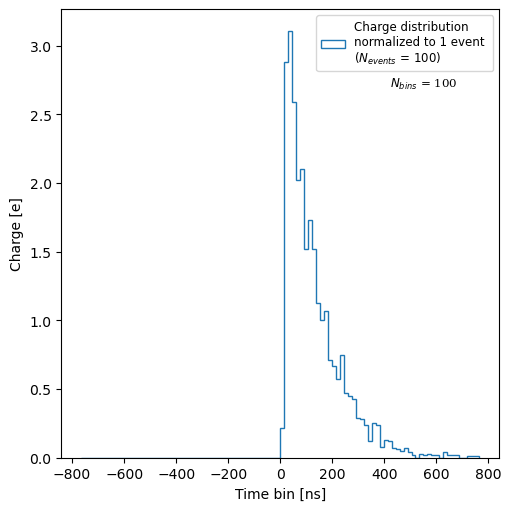

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

n_bins = 100
font_size = 8.5

events, bins, bars = ax.hist(dst.time_bin, n_bins, 
                             weights = dst.charge/n_events,
                             density=False,
                             range=(-1*(dst.time_bin.max()), dst.time_bin.max()),
                             label='Charge distribution \nnormalized to 1 event \n($N_{events}$ = %s)'%(n_events), 
                             histtype='step')

ax.text(0.75, .85, r'$N_{bins}$ = ' + str(n_bins), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.set_ylabel('Charge [e]')
ax.set_xlabel('Time bin [ns]')
ax.legend(fontsize = font_size);


In [27]:
events.sum()

27.24999999999996

<h2> Add dark counts. </h2>

-  <p style="font-size: 17px; color: black;"> Create the noise at 25ºC </p>

In [28]:
dt = 1e-6 # [s] = 1us

In [29]:
tf = dst.time_bin.max()*1e-9 # [s]
t0 = -1*tf # [s]
n_bins = (tf - t0)/dt

In [30]:
n_1pe, n_2pe = noise(dark25, x_talk, t0, tf, dt, n_sensors)

print('We have %s 1pe dark pulses and %s 2pe dark pulses'%(n_1pe, n_2pe))

We have 256 1pe dark pulses and 19 2pe dark pulses


In [31]:
noise_1pe = np.random.randint(t0*1e9, tf*1e9, n_1pe) # [ns]
noise_2pe = np.random.randint(t0*1e9, tf*1e9, n_2pe) # [ns]

t_noise = np.concatenate((noise_1pe, noise_2pe))
c_noise = np.concatenate((1*np.ones(n_1pe), 2*np.ones(n_2pe)))

In [32]:
t_signal = np.asarray(dst.time_bin)
c_signal = np.asarray(dst.charge)

In [33]:
tt = np.concatenate((t_signal, t_noise))
cc = np.concatenate((c_signal/n_events, c_noise))

Total events = 321 = 27 (signal) + 294 (bkg) = 321


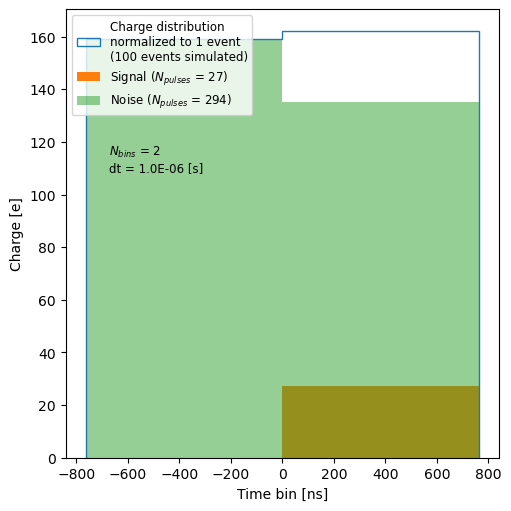

In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

font_size = 8.5


t_low = -1*(tt.max())
t_up = tt.max()

#     dt = (t_up - t_low)*1e-9/n_bins # [s]
n_bins = int((t_up - t_low)*1e-9/dt) + 1

# "Data"
events, bins, bars = ax.hist(tt, n_bins, 
                             weights = cc,  # only part of it has to be normalized (signal part)
                             density=False,
                             range=(t_low, t_up),
                             label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                             histtype='step')


# Signal
s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                   weights = c_signal/n_events,
                                   density=False,
                                   range=(t_low, t_up),
                                   label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                   alpha = 1,
                                   histtype='stepfilled')


# Noise
bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                         weights = c_noise, # noise is already normalized
                                         density=False,
                                         range=(t_low, t_up),
                                         label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                         alpha = 0.5,
                                         histtype='stepfilled')


ax.text(0.1, .7, '$N_{bins}$ = %s \ndt = %.1E [s]'%(n_bins, dt), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

ax.set_ylabel('Charge [e]')
ax.set_xlabel('Time bin [ns]')
ax.legend(fontsize = font_size, loc = 'upper left');

print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                         s_events.sum(), bkg_events.sum(), 
                                                         events.sum()))


In [35]:
events.mean()

160.62500000000074

Total events = 321 = 27 (signal) + 294 (bkg) = 321
Total events = 321 = 27 (signal) + 294 (bkg) = 321
Total events = 321 = 27 (signal) + 294 (bkg) = 321


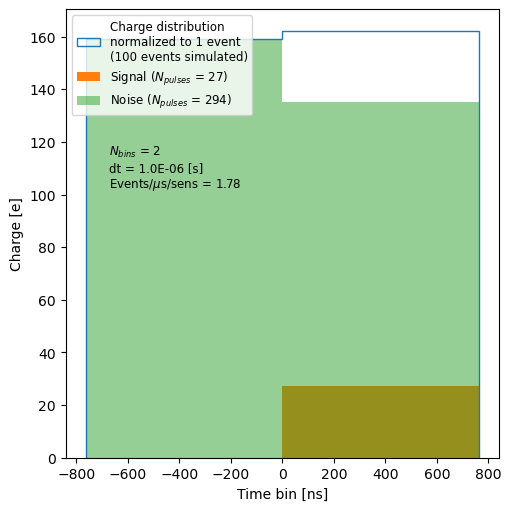

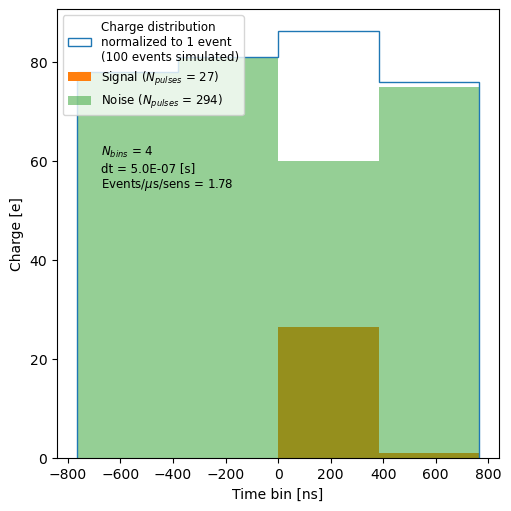

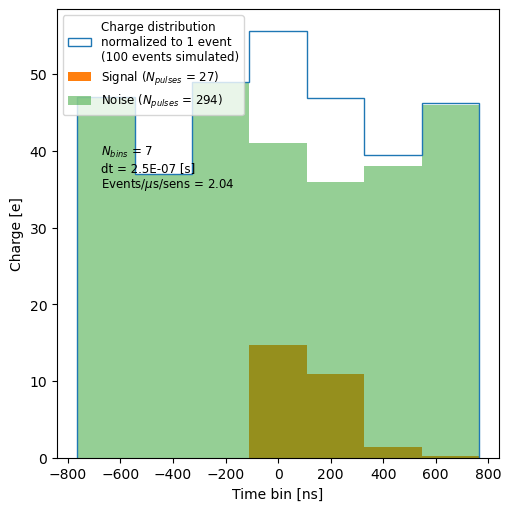

In [36]:
font_size = 8.5

# for n_bins in [200, 150, 100, 70, 50, 20, 10, 5]:
for dt in [1e-6, 0.5e-6, 0.25e-6]:
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

    t_low = -1*(tt.max())
    t_up = tt.max()

#     dt = (t_up - t_low)*1e-9/n_bins # [s]
    n_bins = int((t_up - t_low)*1e-9/dt) + 1

    # "Data"
    events, bins, bars = ax.hist(tt, n_bins, 
                                 weights = cc,  # only part of it has to be normalized (signal part)
                                 density=False,
                                 range=(t_low, t_up),
                                 label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                                 histtype='step')


    # Signal
    s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                       weights = c_signal/n_events,
                                       density=False,
                                       range=(t_low, t_up),
                                       label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                       alpha = 1,
                                       histtype='stepfilled')


    # Noise
    bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                             weights = c_noise, # noise is already normalized
                                             density=False,
                                             range=(t_low, t_up),
                                             label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                             alpha = 0.5,
                                             histtype='stepfilled')


    ax.text(0.1, .7, 
            '$N_{bins}$ = %s \ndt = %.1E [s] \nEvents/$\mu$s/sens = %.2f'%(n_bins, dt, events.mean()*1e-6/dt/n_sensors), 
            transform = ax.transAxes,
            fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
            bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

    ax.set_ylabel('Charge [e]')
    ax.set_xlabel('Time bin [ns]')
    ax.legend(fontsize = font_size, loc = 'upper left');

    print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                             s_events.sum(), bkg_events.sum(), 
                                                             events.sum()))
    


-  <p style="font-size: 17px; color: black;"> Create the noise at different ºC </p>

In [37]:
dt = 1e-6 # [s] = 1us

In [38]:
tf = dst.time_bin.max()*1e-9 # [s]
t0 = -1*tf # [s]
n_bins = (tf - t0)/dt

In [39]:
# temp = 20

We have 256 1pe dark pulses and 19 2pe dark pulses
Total events = 321 = 27 (signal) + 294 (bkg) = 321
Total events = 321 = 27 (signal) + 294 (bkg) = 321
Total events = 321 = 27 (signal) + 294 (bkg) = 321
We have 184 1pe dark pulses and 13 2pe dark pulses
Total events = 237 = 27 (signal) + 210 (bkg) = 237
Total events = 237 = 27 (signal) + 210 (bkg) = 237
Total events = 237 = 27 (signal) + 210 (bkg) = 237
We have 133 1pe dark pulses and 10 2pe dark pulses
Total events = 180 = 27 (signal) + 153 (bkg) = 180
Total events = 180 = 27 (signal) + 153 (bkg) = 180
Total events = 180 = 27 (signal) + 153 (bkg) = 180


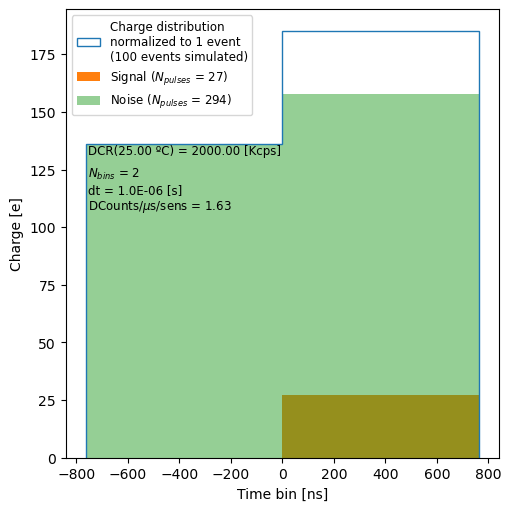

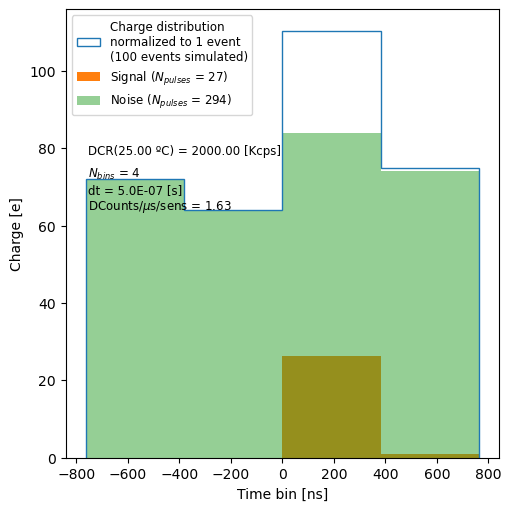

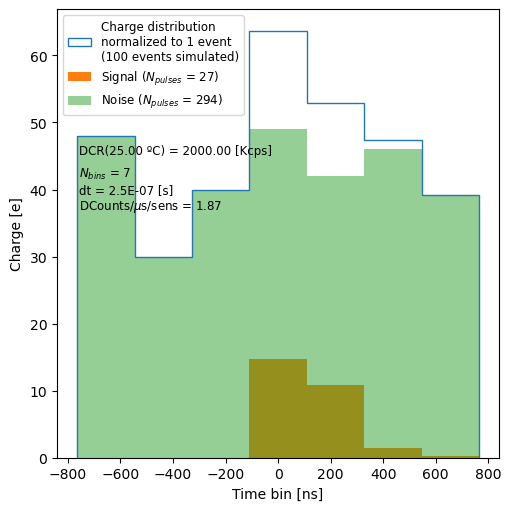

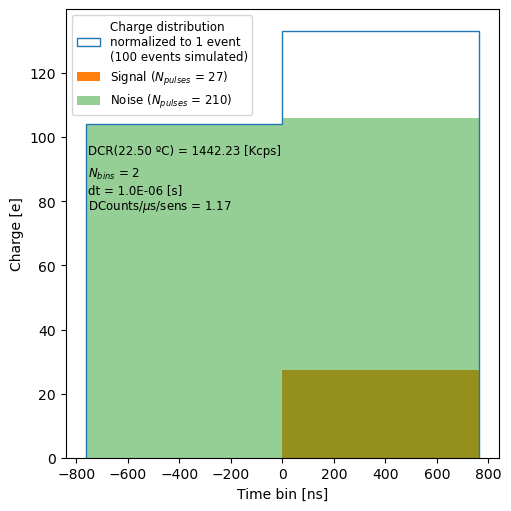

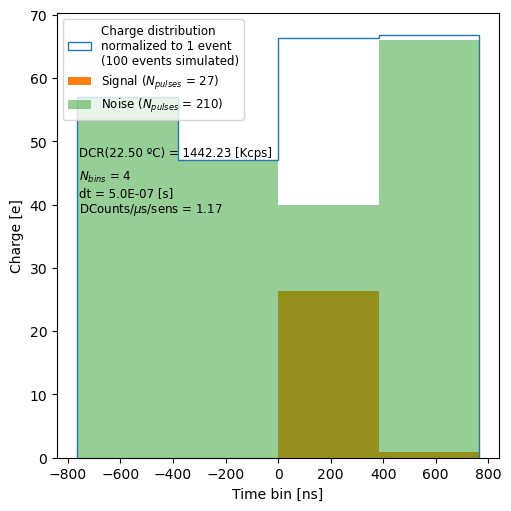

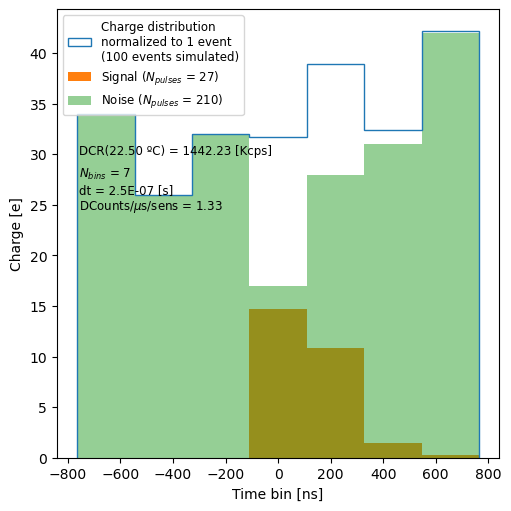

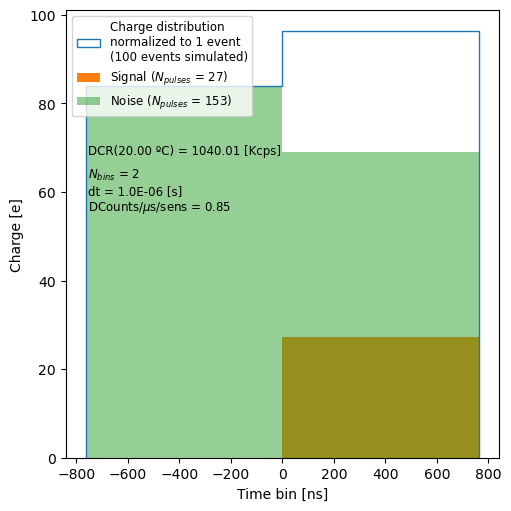

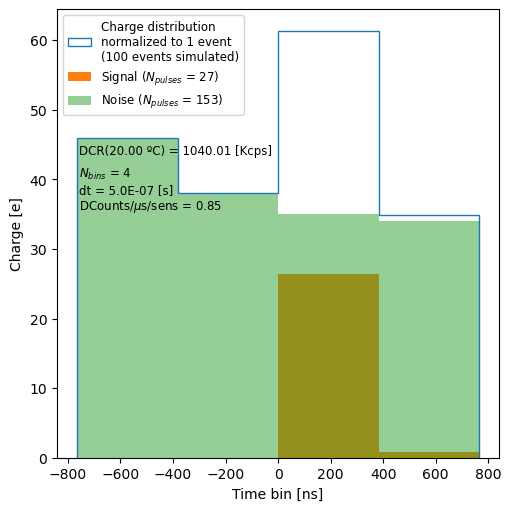

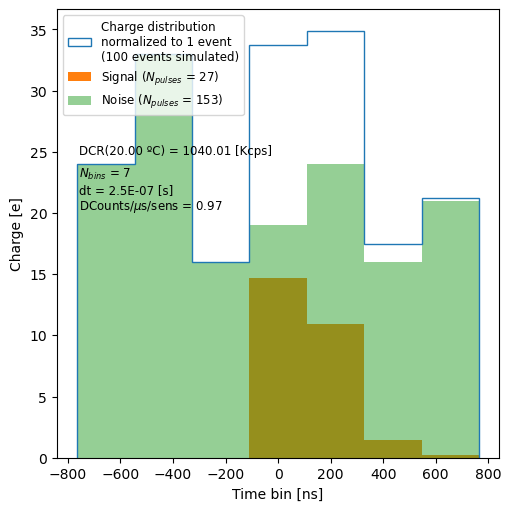

In [40]:
for temp in [25, 22.5, 20]:
    
    DCR = dark_rate(dark25, dT, temp)

    n_1pe, n_2pe = noise(DCR, x_talk, t0, tf, dt, n_sensors)

    print('We have %s 1pe dark pulses and %s 2pe dark pulses'%(n_1pe, n_2pe))

    noise_1pe = np.random.randint(t0*1e9, tf*1e9, n_1pe) # [ns]
    noise_2pe = np.random.randint(t0*1e9, tf*1e9, n_2pe) # [ns]

    t_noise = np.concatenate((noise_1pe, noise_2pe))
    c_noise = np.concatenate((1*np.ones(n_1pe), 2*np.ones(n_2pe)))

    t_signal = np.asarray(dst.time_bin)
    c_signal = np.asarray(dst.charge)

    tt = np.concatenate((t_signal, t_noise))
    cc = np.concatenate((c_signal/n_events, c_noise))


    font_size = 8.5

    # for n_bins in [200, 150, 100, 70, 50, 20, 10, 5]:
    for dt in [1e-6, 0.5e-6, 0.25e-6]:

        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

        t_low = -1*(tt.max())
        t_up = tt.max()

    #     dt = (t_up - t_low)*1e-9/n_bins # [s]
        n_bins = int((t_up - t_low)*1e-9/dt) + 1

        # "Data"
        events, bins, bars = ax.hist(tt, n_bins, 
                                     weights = cc,  # only part of it has to be normalized (signal part)
                                     density=False,
                                     range=(t_low, t_up),
                                     label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                                     histtype='step')


        # Signal
        s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                           weights = c_signal/n_events,
                                           density=False,
                                           range=(t_low, t_up),
                                           label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                           alpha = 1,
                                           histtype='stepfilled')


        # Noise
        bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                                 weights = c_noise, # noise is already normalized
                                                 density=False,
                                                 range=(t_low, t_up),
                                                 label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                                 alpha = 0.5,
                                                 histtype='stepfilled')


        ax.text(0.05, .7, 
                'DCR(%.2f ºC) = %.2f [Kcps]'%(temp, DCR), 
                transform = ax.transAxes,
                fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
                bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))


        ax.text(0.05, .65, 
                '$N_{bins}$ = %s \ndt = %.1E [s] \nDCounts/$\mu$s/sens = %.2f'%(n_bins, dt, bkg_events.mean()*1e-6/dt/n_sensors), 
                transform = ax.transAxes,
                fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
                bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

        ax.set_ylabel('Charge [e]')
        ax.set_xlabel('Time bin [ns]')
        ax.legend(fontsize = font_size, loc = 'upper left');

        print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                                 s_events.sum(), bkg_events.sum(), 
                                                                 events.sum()))

